# Финальная задача проекта

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

## План

- Описание задач и данных
- Загрузка данных и изучение общей информации
- Объединение датафреймов
- Предобработка данных
- Исследовательский анализ данных
    - Анализ количественных признаков
    - Анализ категоральных признаков
    - Анализ мультиколлинеарности количественных признаков
    - Анализ мультиколлинеарности категоральных признаков
- Построение моделей
    - Первичное тестирование и отбор моделей
    - Подбор гиперпараметров
    - Тестирование финальных моделей
    - Проверка модели на адекватность
- Заключение

## Загрузка данных и изучение общей информации

In [14]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import lightgbm as lgb
from lightgbm import LGBMClassifier

import xgboost as xgb
from catboost import CatBoostClassifier, Pool, cv as catboost_cv

from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

import sklearn.metrics as metrics
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, confusion_matrix
from sklearn.utils import shuffle

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.metrics import accuracy_score

import phik
from phik.report import plot_correlation_matrix
from phik import report

from scipy import stats as st

random_state = 120922

import warnings
warnings.filterwarnings('ignore')

import time

In [15]:
try:
    contract = pd.read_csv('final_provider/contract.csv')
    internet = pd.read_csv('final_provider/internet.csv')
    personal = pd.read_csv('final_provider/personal.csv')
    phone = pd.read_csv('final_provider/phone.csv')
except:
    contract = pd.read_csv('/datasets/final_provider/contract.csv')
    internet = pd.read_csv('/datasets/final_provider/internet.csv')
    personal = pd.read_csv('/datasets/final_provider/personal.csv')
    phone = pd.read_csv('/datasets/final_provider/phone.csv')

In [16]:
display(personal.head(2))
display(contract.head(2))
display(internet.head(2))
display(phone.head(2))

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No


### Проверка на дубликаты строк в датафреймах

In [17]:
print("Дубликатов в датафрейме personal:", personal.duplicated().sum())
print("Дубликатов в датафрейме contract:", contract.duplicated().sum())
print("Дубликатов в датафрейме internet:", internet.duplicated().sum())
print("Дубликатов в датафрейме phone:", phone.duplicated().sum())

Дубликатов в датафрейме personal: 0
Дубликатов в датафрейме contract: 0
Дубликатов в датафрейме internet: 0
Дубликатов в датафрейме phone: 0


Вывод:

Дубликаты отсутствуют

### Проверка датафреймов на NULL значения

In [18]:
personal.info()
contract.info()
internet.info()
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCh

Вывод:

Значения NULL отсутствуют

### Анализ уникальных клиентов

In [19]:
print('Количество уникальных клиентов в таблице personal:', len(personal['customerID'].unique()))
print('Количество уникальных клиентов в таблице contract:', len(contract['customerID'].unique()))

Количество уникальных клиентов в таблице personal: 7043
Количество уникальных клиентов в таблице contract: 7043


Вывод

В таблице contract количество строк такое же, как и количество уникальных клиентов, то есть у одного клиента один договор

Вывод по общей информации по таблицам

- В таблицах нет дубликатов по клиентам и нет NULL значений;
- В таблице contract количество строк такое же как и количество уникальных клиентов, то есть у одного клиента один догвор
- В таблицах internet и phone меньше строк чем уникальных клиентов, необходимо будет обратить внимание во время объединения

### Анализ значений таблицы personal

In [20]:
print("Значения столбца Gender:")
display(personal['gender'].unique())
print("")
print("Значения столбца SeniorCitizen:")
display(personal['SeniorCitizen'].unique())
print("")
print("Значения столбца Partner:")
display(personal['Partner'].unique())
print("")
print("Значения столбца Dependents:")
display(personal['Dependents'].unique())

Значения столбца Gender:


array(['Female', 'Male'], dtype=object)


Значения столбца SeniorCitizen:


array([0, 1])


Значения столбца Partner:


array(['Yes', 'No'], dtype=object)


Значения столбца Dependents:


array(['No', 'Yes'], dtype=object)

Вывод

Необходимо перевести значения:
- столбца Gender к категоральному;
- столбцов Partner и Dependents к численному (0 и 1).

### Анализ значений таблицы contract

In [21]:
print("Значения столбца BeginDate:")
display(sorted(contract['BeginDate'].unique()))
print("")
print("Значения столбца EndDate:")
display(sorted(contract['EndDate'].unique()))
print("")
print("Значения столбца Type:")
display(contract['Type'].unique())
print("")
print("Значения столбца PaperlessBilling:")
display(contract['PaperlessBilling'].unique())
print("")
print("Значения столбца PaymentMethod:")
display(contract['PaymentMethod'].unique())
print("")
print("Значения столбца MonthlyCharges:")
display(contract['MonthlyCharges'].unique())
print("")
print("Значения столбца TotalCharges:")
display(contract['TotalCharges'].unique())

Значения столбца BeginDate:


['2013-10-01',
 '2013-11-01',
 '2013-12-01',
 '2014-01-01',
 '2014-02-01',
 '2014-03-01',
 '2014-04-01',
 '2014-05-01',
 '2014-06-01',
 '2014-07-01',
 '2014-08-01',
 '2014-09-01',
 '2014-10-01',
 '2014-11-01',
 '2014-12-01',
 '2015-01-01',
 '2015-02-01',
 '2015-03-01',
 '2015-04-01',
 '2015-05-01',
 '2015-06-01',
 '2015-07-01',
 '2015-08-01',
 '2015-09-01',
 '2015-10-01',
 '2015-11-01',
 '2015-12-01',
 '2016-01-01',
 '2016-02-01',
 '2016-03-01',
 '2016-04-01',
 '2016-05-01',
 '2016-06-01',
 '2016-07-01',
 '2016-08-01',
 '2016-09-01',
 '2016-10-01',
 '2016-11-01',
 '2016-12-01',
 '2017-01-01',
 '2017-02-01',
 '2017-03-01',
 '2017-04-01',
 '2017-05-01',
 '2017-06-01',
 '2017-07-01',
 '2017-08-01',
 '2017-09-01',
 '2017-10-01',
 '2017-11-01',
 '2017-12-01',
 '2018-01-01',
 '2018-02-01',
 '2018-03-01',
 '2018-04-01',
 '2018-05-01',
 '2018-06-01',
 '2018-07-01',
 '2018-08-01',
 '2018-09-01',
 '2018-10-01',
 '2018-11-01',
 '2018-12-01',
 '2019-01-01',
 '2019-02-01',
 '2019-03-01',
 '2019-04-


Значения столбца EndDate:


['2019-10-01 00:00:00',
 '2019-11-01 00:00:00',
 '2019-12-01 00:00:00',
 '2020-01-01 00:00:00',
 'No']


Значения столбца Type:


array(['Month-to-month', 'One year', 'Two year'], dtype=object)


Значения столбца PaperlessBilling:


array(['Yes', 'No'], dtype=object)


Значения столбца PaymentMethod:


array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)


Значения столбца MonthlyCharges:


array([29.85, 56.95, 53.85, ..., 63.1 , 44.2 , 78.7 ])


Значения столбца TotalCharges:


array(['29.85', '1889.5', '108.15', ..., '346.45', '306.6', '6844.5'],
      dtype=object)

Вывод

Необходимо перевести значения:
- столбца BeginDate к типу даты;
- на основе столбца EndDate сформировать целевой признак (название Exit с наполнением no это 1);
- столбца TotalCharges к типу float;
- столбцов PaperlessBilling к численному (0 и 1).

Необходимо дополнительно проанализировать значения столбца EndDate в блоке исследовательский анализ данных.

### Анализ значений таблицы internet

In [22]:
print("Значения столбца InternetService:")
display(internet['InternetService'].unique())
print("")
print("Значения столбца OnlineSecurity:")
display(internet['OnlineSecurity'].unique())
print("")
print("Значения столбца OnlineBackup:")
display(internet['OnlineBackup'].unique())
print("")
print("Значения столбца DeviceProtection:")
display(internet['DeviceProtection'].unique())
print("")
print("Значения столбца TechSupport:")
display(internet['TechSupport'].unique()) 
print("")
print("Значения столбца StreamingTV:")
display(internet['StreamingTV'].unique())
print("")
print("Значения столбца StreamingMovies:")
display(internet['StreamingMovies'].unique())

Значения столбца InternetService:


array(['DSL', 'Fiber optic'], dtype=object)


Значения столбца OnlineSecurity:


array(['No', 'Yes'], dtype=object)


Значения столбца OnlineBackup:


array(['Yes', 'No'], dtype=object)


Значения столбца DeviceProtection:


array(['No', 'Yes'], dtype=object)


Значения столбца TechSupport:


array(['No', 'Yes'], dtype=object)


Значения столбца StreamingTV:


array(['No', 'Yes'], dtype=object)


Значения столбца StreamingMovies:


array(['No', 'Yes'], dtype=object)

Вывод

Необходимо перевести значения:
- столбца InternetService к категоральному типу;
- столбцов OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies к численному (0 и 1).

### Анализ значений таблицы phone

In [23]:
print("Значения столбца MultipleLines:")
display(phone['MultipleLines'].unique())

Значения столбца MultipleLines:


array(['No', 'Yes'], dtype=object)

Вывод

Необходимо перевести значения:
- столбца MultipleLines к численному (0 и 1).

### Вывод

Необходимо перевести значения из таблицы personal:
- столбцов Partner к численному (0 и 1).

Необходимо перевести значения из таблицы contract:
- столбца BeginDate к типу даты;
- на основе столбца EndDate сформировать целевой признак (название Exit с наполнением no это 1);
- столбца TotalCharges к типу float;
- столбцов PaperlessBilling и Dependents к численному (0 и 1).

Необходимо перевести значения из таблицы internet:
- столбца InternetService к категоральному типу;
- столбцов OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies к численному (0 и 1).

Необходимо перевести значения из таблицы phone:
- столбца MultipleLines к численному (0 и 1).

## Объединение датафреймов

Перед объединением таблиц необходимо скорректировать названия столбцов что бы они были в едином стиле

In [24]:
personal.rename(columns = {'customerID' : 'CustomerID', 'gender' : 'Gender'}, inplace = True) 
contract.rename(columns = {'customerID' : 'CustomerID'}, inplace = True)
internet.rename(columns = {'customerID' : 'CustomerID'}, inplace = True) 
phone.rename(columns = {'customerID' : 'CustomerID'}, inplace = True) 

Объединение таблиц

In [25]:
full_df = personal.merge(contract,on='CustomerID', how='left').merge(internet,on='CustomerID', how='left').merge(phone,on='CustomerID', how='left')


In [26]:
full_df.head(2)

,CustomerID,Gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,Female,0,Yes,No,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,Male,0,No,No,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,DSL,Yes,No,Yes,No,No,No,No


In [27]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CustomerID        7043 non-null   object 
 1   Gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   BeginDate         7043 non-null   object 
 6   EndDate           7043 non-null   object 
 7   Type              7043 non-null   object 
 8   PaperlessBilling  7043 non-null   object 
 9   PaymentMethod     7043 non-null   object 
 10  MonthlyCharges    7043 non-null   float64
 11  TotalCharges      7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


### Вывод

По результатам объединения образовались значения NULL, необходимо их будет заполнить в предобработке данных

## Предобработка данных

### Формирование целевого признака

In [28]:
def target(a):
    if a == 'No':
        val = 0
    else:
        val = 1
    return val


full_df['Exit'] = full_df['EndDate'].apply(lambda score: target(score))

In [29]:
full_df.head(2)

,CustomerID,Gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,...,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Exit
0,7590-VHVEG,Female,0,Yes,No,2020-01-01,No,Month-to-month,Yes,Electronic check,...,29.85,DSL,No,Yes,No,No,No,No,NaN,0
1,5575-GNVDE,Male,0,No,No,2017-04-01,No,One year,No,Mailed check,...,1889.5,DSL,Yes,No,Yes,No,No,No,No,0


Вывод

Целевой признак сформирован 'Exit' - открыт договор или закрыт на дату 2020-02-01

### Изменения типов колонок

#### Изменение типа колонки BeginDate на datetime

In [30]:
full_df['BeginDate'] = full_df['BeginDate'].apply(pd.to_datetime)


In [31]:
print('Тип колонки BeginDate:', full_df['BeginDate'].dtype)

Тип колонки BeginDate: datetime64[ns]


#### Изменение типа колонки TotalCharges на float64

In [32]:
full_df['TotalCharges'] = pd.to_numeric(full_df['TotalCharges'].replace(" ", ""), "coerce")

In [33]:
print('Тип колонки TotalCharges:', full_df['TotalCharges'].dtype)

Тип колонки TotalCharges: float64


Проверим не появились ли NULL значения 

In [34]:
print("Количество NULL значений в колонке TotalCharges:", full_df['TotalCharges'].isna().sum())

Количество NULL значений в колонке TotalCharges: 11


Удалим эти строки, на качество не отразится посколько их менее 1%

In [35]:
full_df = full_df[full_df['TotalCharges'].notna()]

#### Изменение типов столбцов к численному (0 и 1) по списку

In [36]:
bool_col = ['Partner', 'Dependents', 'PaperlessBilling', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']


In [37]:
def bool(a):
    if a == 'Yes':
        val = 1
    else:
        val = 0
    return val

for col in bool_col:
    full_df[col] = full_df[col].apply(bool)
    
full_df['Gender'] = (full_df['Gender'] == 'Male').astype('int')
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   CustomerID        7032 non-null   object        
 1   Gender            7032 non-null   int64         
 2   SeniorCitizen     7032 non-null   int64         
 3   Partner           7032 non-null   int64         
 4   Dependents        7032 non-null   int64         
 5   BeginDate         7032 non-null   datetime64[ns]
 6   EndDate           7032 non-null   object        
 7   Type              7032 non-null   object        
 8   PaperlessBilling  7032 non-null   int64         
 9   PaymentMethod     7032 non-null   object        
 10  MonthlyCharges    7032 non-null   float64       
 11  TotalCharges      7032 non-null   float64       
 12  InternetService   5512 non-null   object        
 13  OnlineSecurity    7032 non-null   int64         
 14  OnlineBackup      7032 n

### Добавление колонки количества прошедших дней с начала заключения договора

Сформируем колонку отображающую срок жизни клиента на обслуживании

In [38]:
full_df.loc[full_df['EndDate'] == 'No',  'EndDate'] = pd.to_datetime('2020-02-01 00:00:00')
full_df['EndDate'] = pd.to_datetime(full_df['EndDate'])
full_df['Lifetime(days)'] =  (pd.to_datetime(full_df['EndDate']) - full_df['BeginDate']).dt.days

### Заполнение пропусков

In [39]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   CustomerID        7032 non-null   object        
 1   Gender            7032 non-null   int64         
 2   SeniorCitizen     7032 non-null   int64         
 3   Partner           7032 non-null   int64         
 4   Dependents        7032 non-null   int64         
 5   BeginDate         7032 non-null   datetime64[ns]
 6   EndDate           7032 non-null   datetime64[ns]
 7   Type              7032 non-null   object        
 8   PaperlessBilling  7032 non-null   int64         
 9   PaymentMethod     7032 non-null   object        
 10  MonthlyCharges    7032 non-null   float64       
 11  TotalCharges      7032 non-null   float64       
 12  InternetService   5512 non-null   object        
 13  OnlineSecurity    7032 non-null   int64         
 14  OnlineBackup      7032 n

Пропуски образованы отсутствием данных в таблицах phone и internet, данные в таблице отсутствуют когда у клиента либо не подключены услуги интернета либо не подключена услуга телефон.<br>
Соответственно заполняем пропуски значением 'None' и 0 в зависимости от колонки.

In [40]:
full_df[['InternetService', 'PaymentMethod', 'Type']] = full_df[['InternetService', 'PaymentMethod', 'Type']].fillna(value='None')

In [41]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   CustomerID        7032 non-null   object        
 1   Gender            7032 non-null   int64         
 2   SeniorCitizen     7032 non-null   int64         
 3   Partner           7032 non-null   int64         
 4   Dependents        7032 non-null   int64         
 5   BeginDate         7032 non-null   datetime64[ns]
 6   EndDate           7032 non-null   datetime64[ns]
 7   Type              7032 non-null   object        
 8   PaperlessBilling  7032 non-null   int64         
 9   PaymentMethod     7032 non-null   object        
 10  MonthlyCharges    7032 non-null   float64       
 11  TotalCharges      7032 non-null   float64       
 12  InternetService   7032 non-null   object        
 13  OnlineSecurity    7032 non-null   int64         
 14  OnlineBackup      7032 n

Вывод

Пропуски отсутствуют

### Вывод

- Целевой признак сформирован 'Exit' - открыт договор или закрыт на дату 2020-02-01
- Заменены типы колонок 
    - тип колонки 'BeginDate' на datetime
    - тип колонки 'TotalCharges' на float64
    - изменены типы столбцов с Yes, No на 1, 0 по списку 'Partner', 'Dependents', 'PaperlessBilling', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines'
    - Сформирована колонка отображающая срок жизни клиента на обслуживании Lifetime(days)
    - Пропуски в колонке 'InternetService' заполнены значением None

## Исследовательский анализ данных

### Анализ количественных признаков

#### Анализ колонки TotalCharges

<AxesSubplot: >

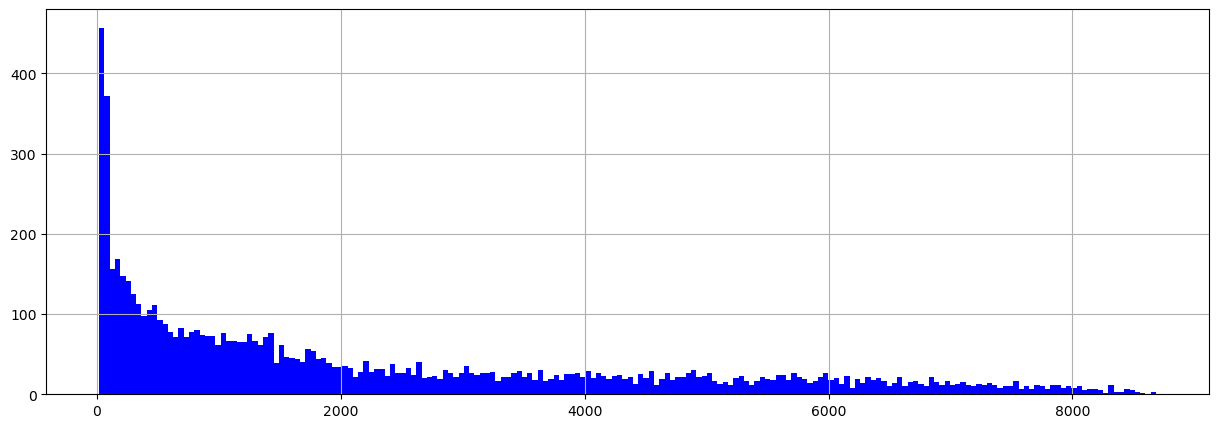

In [42]:
full_df['TotalCharges'].hist(bins=200, figsize=(15,5), color = "blue")

Логичное распределение без всплеском, кроме как около нуля, посмотрим его более детально

<AxesSubplot: >

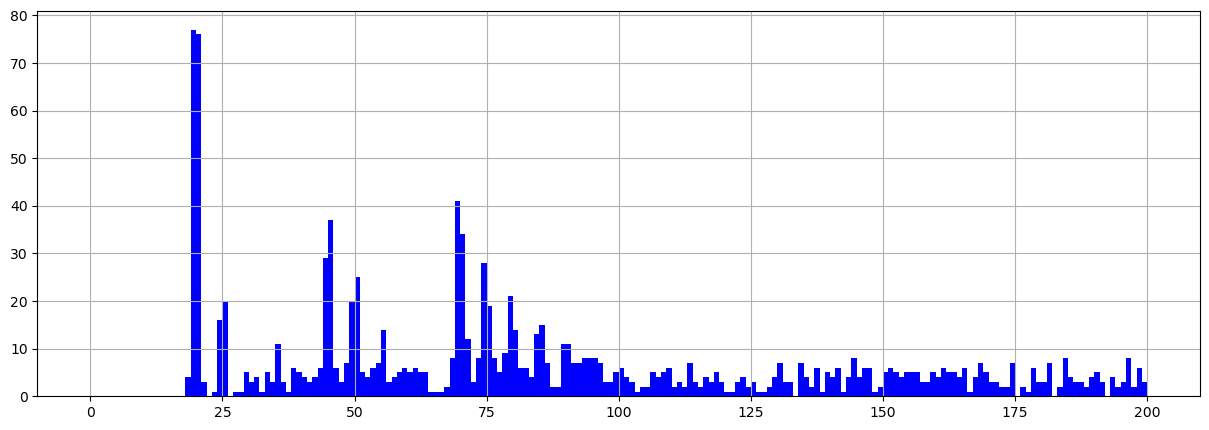

In [43]:
full_df['TotalCharges'].hist(bins=200, figsize=(15,5), range=[0, 200], color = "blue")

Видим характерные пики возле определнных значений, что обозначает фиксированные стоимости услуг, которыми пользуется большое количество людей, либо типовые договора, так что все вполне объяснимо

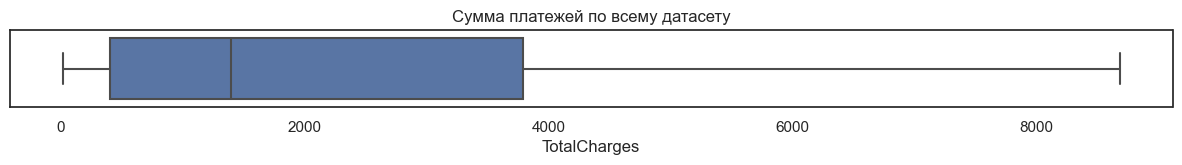

Среднее значение: 1397
50% датасета находится между: 401 и 3794






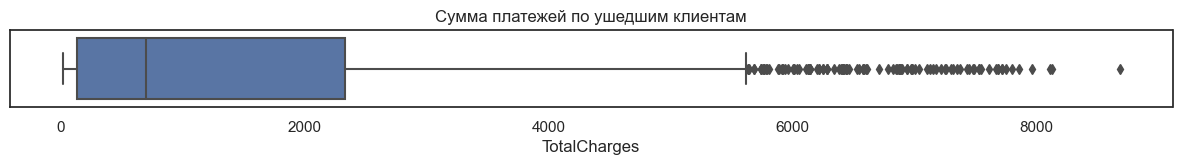

Среднее значение: 703
50% датасета находится между: 134 и 2331






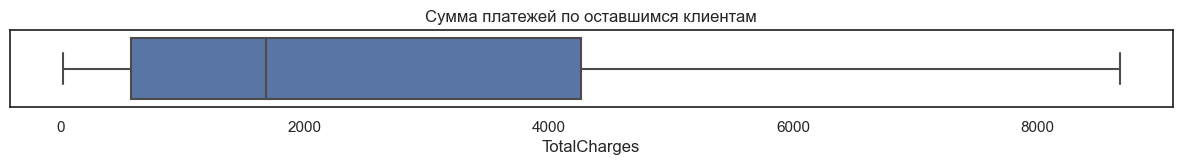

Среднее значение: 1683
50% датасета находится между: 577 и 4264


In [44]:
sns.set(rc={'figure.figsize':(15,1)})
sns.set_style('white')

sns.boxplot(x=full_df["TotalCharges"])
plt.title('Сумма платежей по всему датасету')
plt.show()
quantiles = np.quantile(full_df["TotalCharges"], np.array([0.00, 0.25, 0.50, 0.75, 1.00]))
print("Среднее значение:", int(quantiles[2]))
print("50% датасета находится между:", int(quantiles[1]), "и", int(quantiles[3]))
print('')
print('')
print('')
print('')

sns.boxplot(x=full_df[full_df["Exit"] == 1]["TotalCharges"])
plt.title('Сумма платежей по ушедшим клиентам')
plt.show()
quantiles = np.quantile(full_df[full_df["Exit"] == 1]["TotalCharges"], np.array([0.00, 0.25, 0.50, 0.75, 1.00]))
print("Среднее значение:", int(quantiles[2]))
print("50% датасета находится между:", int(quantiles[1]), "и", int(quantiles[3]))
print('')
print('')
print('')
print('')

sns.boxplot(x=full_df[full_df["Exit"] == 0]["TotalCharges"])
plt.title('Сумма платежей по оставшимся клиентам')
plt.show()
quantiles = np.quantile(full_df[full_df["Exit"] == 0]["TotalCharges"], np.array([0.00, 0.25, 0.50, 0.75, 1.00]))
print("Среднее значение:", int(quantiles[2]))
print("50% датасета находится между:", int(quantiles[1]), "и", int(quantiles[3]))

Проанализируем TotalCharges в зависимости от целевого признака

Text(0.5, 1.0, 'Распределение суммы оплаты в зависимости от статуса клиента')

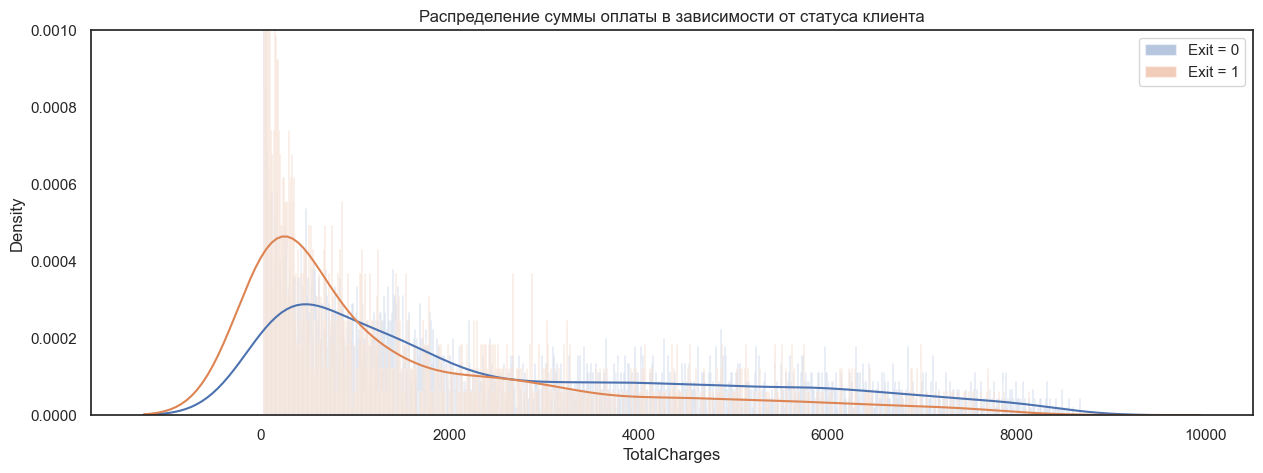

In [45]:
plt.figure(figsize=(15, 5))
sns.distplot(full_df[full_df['Exit']==0]['TotalCharges'], label='Exit = 0', bins=1000)
sns.distplot(full_df[full_df['Exit']==1]['TotalCharges'], label='Exit = 1', bins=1000)
plt.ylim(0, 0.001)
plt.legend()
plt.title('Распределение суммы оплаты в зависимости от статуса клиента')


Вывод

По результатам анализа:
- 'TotalCharges' имеет влияние на целевой признак
- Средняя сумма платежей по ушедшим клиентам в два раза меньше, чем по оставшимся клиентам

#### Анализ колонки MonthlyCharges

<AxesSubplot: >

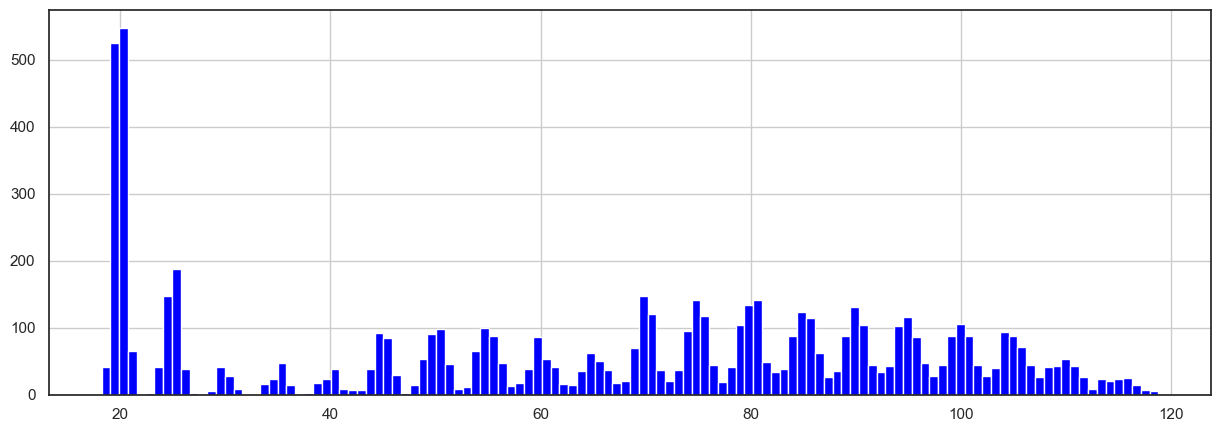

In [46]:
full_df['MonthlyCharges'].hist(bins=120, figsize=(15,5), color = "blue")

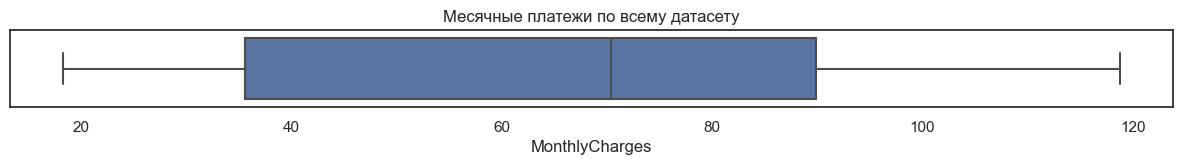

Среднее значение: 70
50% датасета находится между: 35 и 89






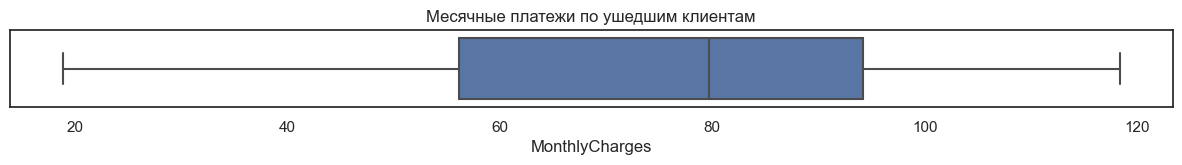

Среднее значение: 79
50% датасета находится между: 56 и 94






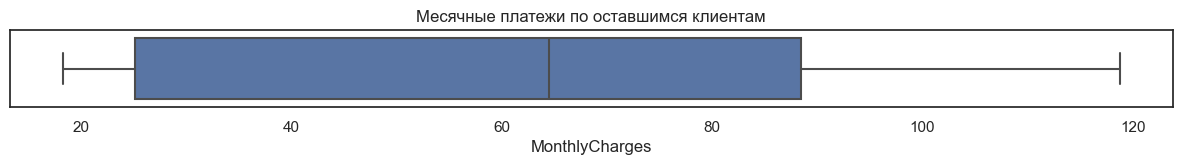

Среднее значение: 64
50% датасета находится между: 25 и 88


In [47]:
sns.set(rc={'figure.figsize':(15,1)})
sns.set_style('white')

sns.boxplot(x=full_df["MonthlyCharges"])
plt.title('Месячные платежи по всему датасету')
plt.show()
quantiles = np.quantile(full_df["MonthlyCharges"], np.array([0.00, 0.25, 0.50, 0.75, 1.00]))
print("Среднее значение:", int(quantiles[2]))
print("50% датасета находится между:", int(quantiles[1]), "и", int(quantiles[3]))
print('')
print('')
print('')
print('')

sns.boxplot(x=full_df[full_df["Exit"] == 1]["MonthlyCharges"])
plt.title('Месячные платежи по ушедшим клиентам')
plt.show()
quantiles = np.quantile(full_df[full_df["Exit"] == 1]["MonthlyCharges"], np.array([0.00, 0.25, 0.50, 0.75, 1.00]))
print("Среднее значение:", int(quantiles[2]))
print("50% датасета находится между:", int(quantiles[1]), "и", int(quantiles[3]))
print('')
print('')
print('')
print('')

sns.boxplot(x=full_df[full_df["Exit"] == 0]["MonthlyCharges"])
plt.title('Месячные платежи по оставшимся клиентам')
plt.show()
quantiles = np.quantile(full_df[full_df["Exit"] == 0]["MonthlyCharges"], np.array([0.00, 0.25, 0.50, 0.75, 1.00]))
print("Среднее значение:", int(quantiles[2]))
print("50% датасета находится между:", int(quantiles[1]), "и", int(quantiles[3]))

Проанализируем MonthlyCharges в зависимости от целевого признака

Text(0.5, 1.0, 'Распределение помесячной оплаты в зависимости от статуса клиента')

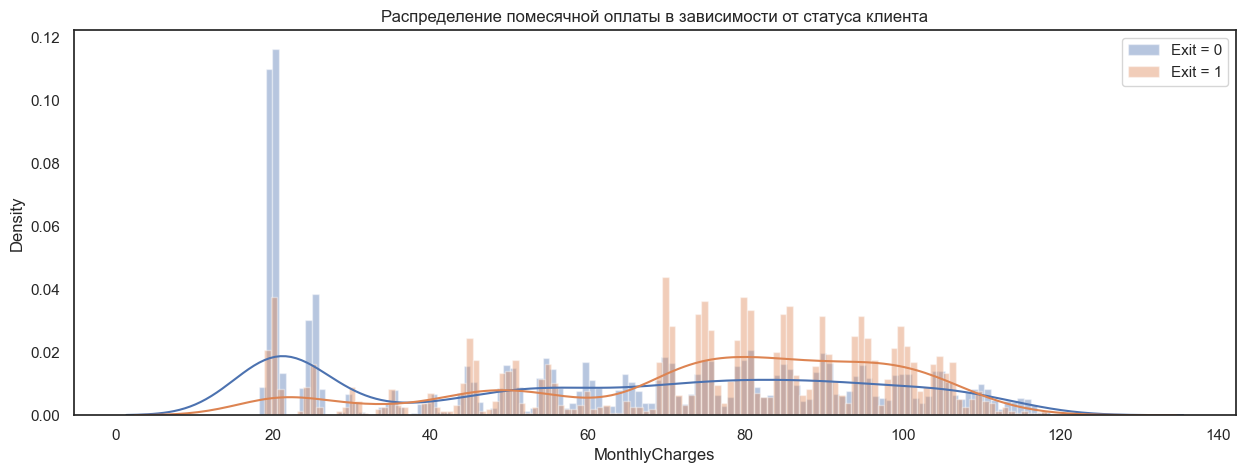

In [48]:
plt.figure(figsize=(15, 5))
sns.distplot(full_df[full_df['Exit']==0]['MonthlyCharges'], label='Exit = 0', bins=120)
sns.distplot(full_df[full_df['Exit']==1]['MonthlyCharges'], label='Exit = 1', bins=120)
plt.legend()
plt.title('Распределение помесячной оплаты в зависимости от статуса клиента')


Вывод

По результатам анализа:
- 'MonthlyCharges' имеет влияние на целевой признак
- ушедшие клиенты в основном платили в месяц больше, чем оставшиеся клиенты

#### Анализ колонки Lifetime(days)

In [49]:
sns.set(rc={'figure.figsize':(15,5)})

<AxesSubplot: xlabel='BeginDate'>

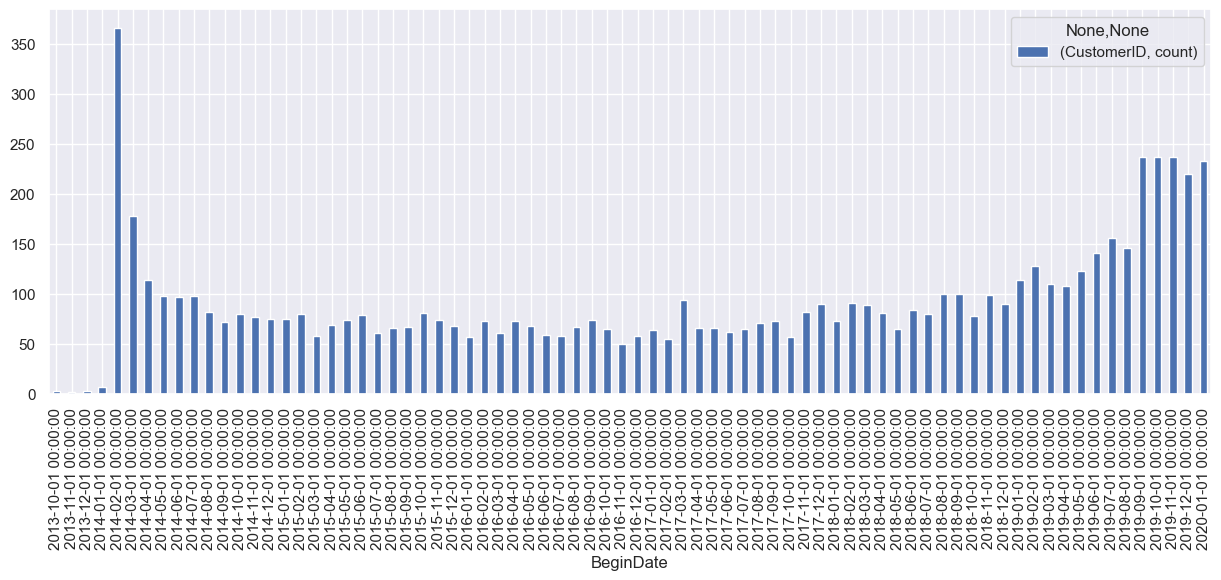

In [50]:
full_df[['BeginDate', 'CustomerID']].sort_values('BeginDate').groupby('BeginDate').agg(['count']).plot(kind='bar')

<AxesSubplot: xlabel='EndDate'>

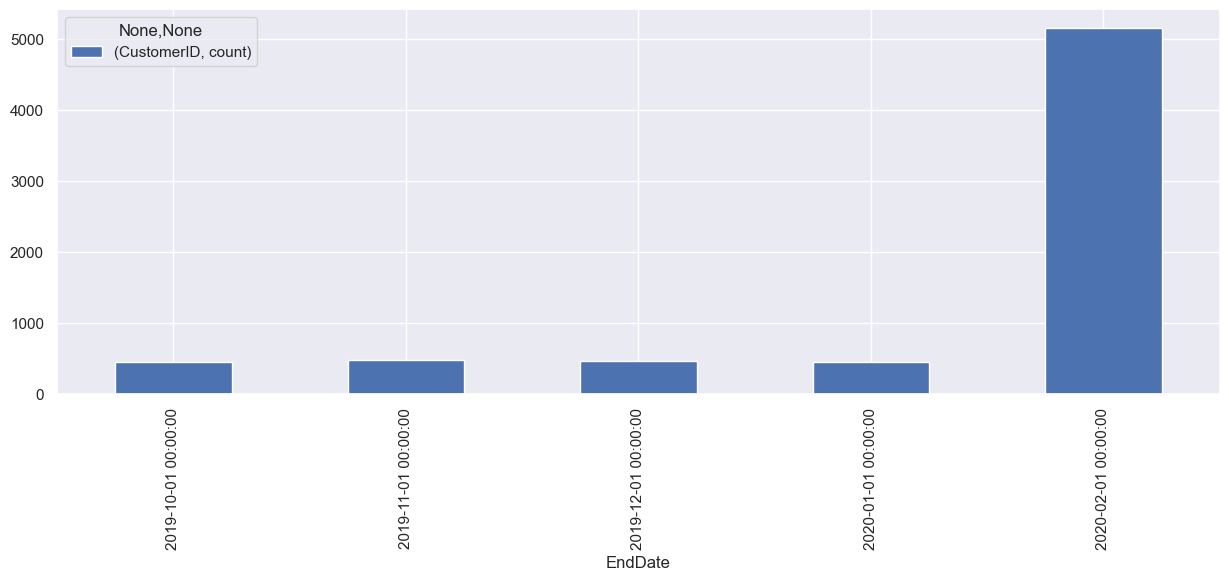

In [51]:
full_df[['EndDate', 'CustomerID']].sort_values('EndDate').groupby('EndDate').agg(['count']).plot(kind='bar')

Как мы видим, сервис активно работает с 2014 года, однако EndDate начал отслеживаться только с октября 2019 года, посмотрим на зависимость ухода клиента от срока жизни клиентов на контракте и в зависимости от даты прихода

<AxesSubplot: xlabel='BeginDate'>

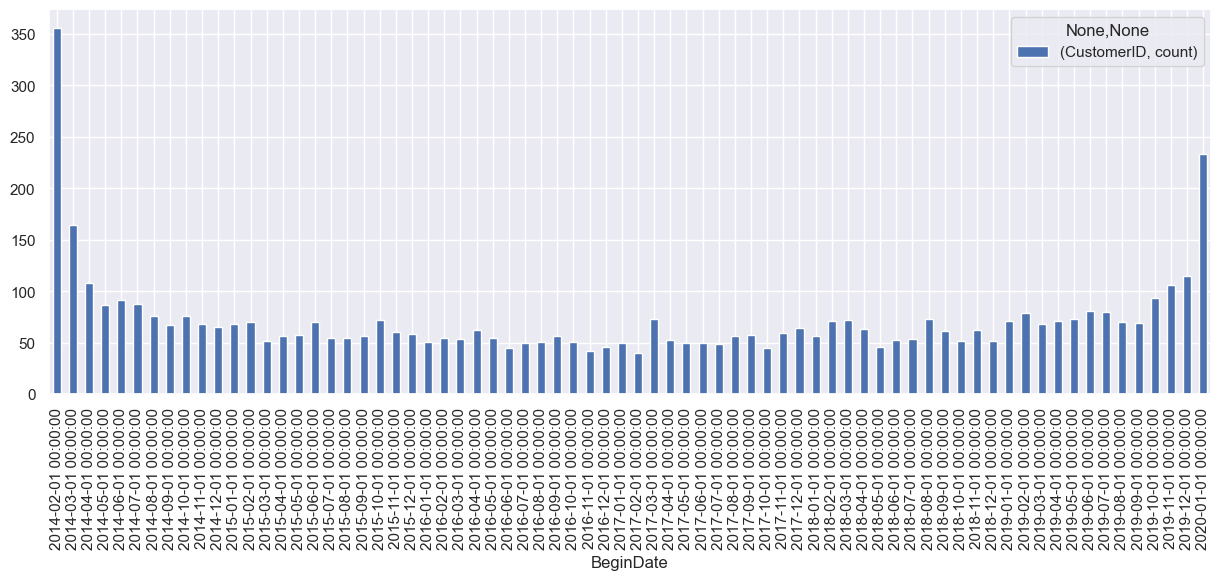

In [52]:
full_df[full_df['Exit']==0][['BeginDate', 'CustomerID']].sort_values('BeginDate').groupby('BeginDate').agg(['count']).plot(kind='bar')

<AxesSubplot: >

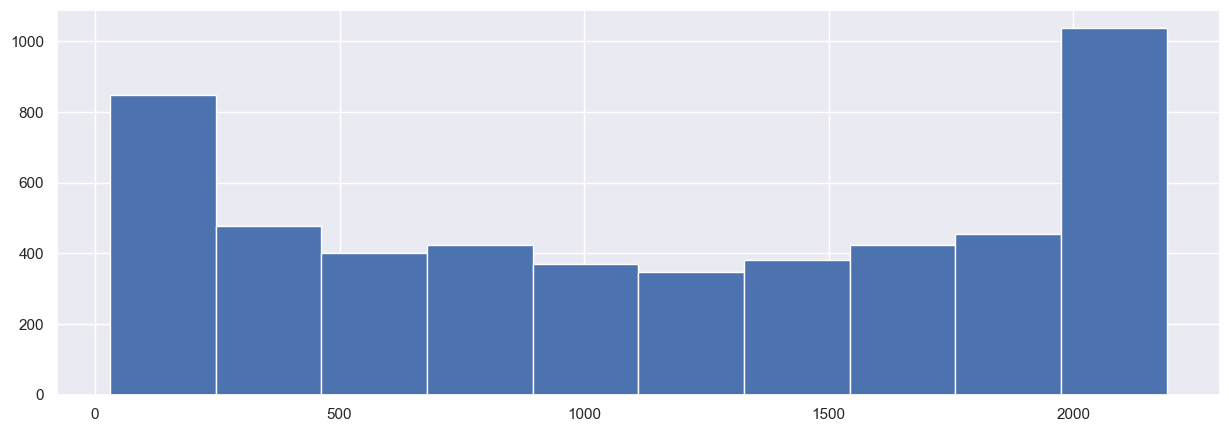

In [53]:
full_df[full_df['Exit'] == 0]['Lifetime(days)'].hist()

<AxesSubplot: xlabel='BeginDate'>

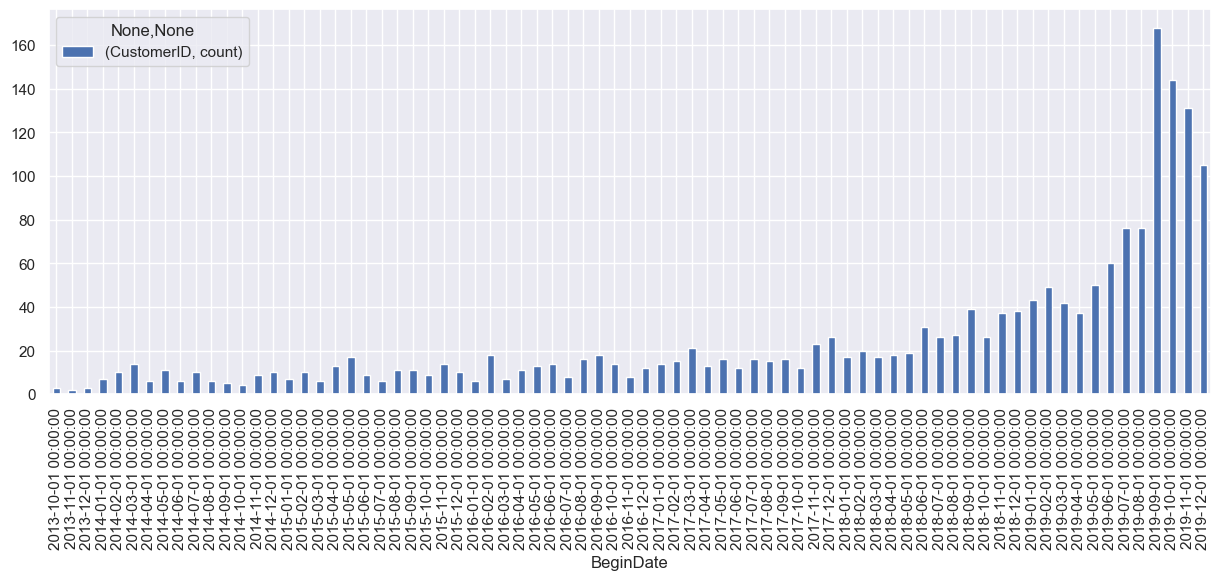

In [54]:
full_df[full_df['Exit']==1][['BeginDate', 'CustomerID']].sort_values('BeginDate').groupby('BeginDate').agg(['count']).plot(kind='bar')

<AxesSubplot: >

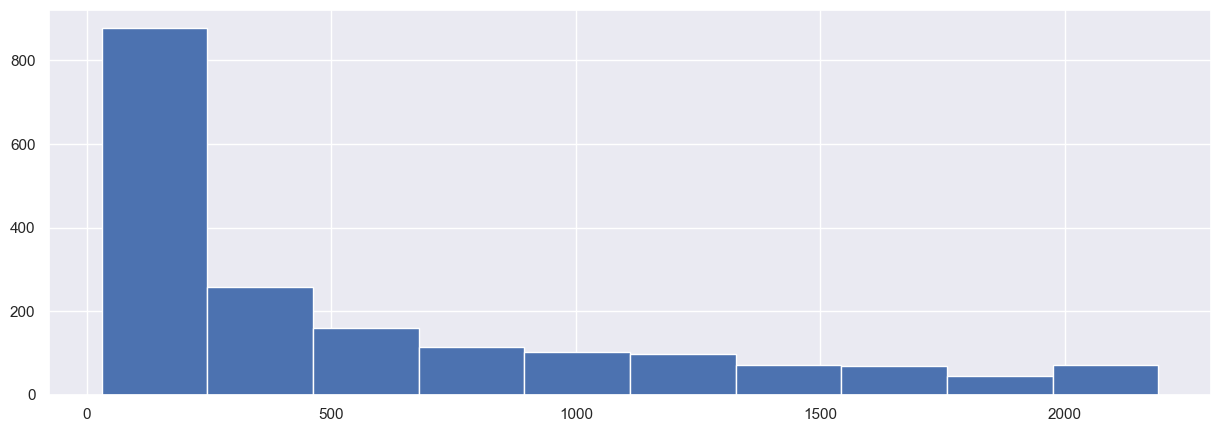

In [55]:
full_df[full_df['Exit'] == 1]['Lifetime(days)'].hist()

Вывод

По характеру дат в колонке EndDate, предполагаем, что мониторингом ушедших клиентов занялись недавно.<br>
При анализе времени жизни клиента на обслуживании в разрезе ушел клиент или нет мы видим прямую зависимость, чем меньше срок жизни клиента на обслуживании тем больше вероятность, что он уйдет. 

Необходимо учитывать этот факт при построении моделей машинного обучения.

Вывод

По результатам анализа:
- 'TotalCharges' и 'MonthlyCharges' имеют влияние на целевой признак
- Средняя сумма платежей по ушедшим клиентам в два раза меньше, чем по оставшимся клиентам
- Ушедшие клиенты в основном платили в месяц больше, чем оставшиеся клиенты

### Анализ категоральных признаков

In [56]:
cat_list = filter(lambda v: v not in ['Lifetime(days)','MonthlyCharges', 'TotalCharges', 'BeginDate', 'EndDate'], list(full_df)) 

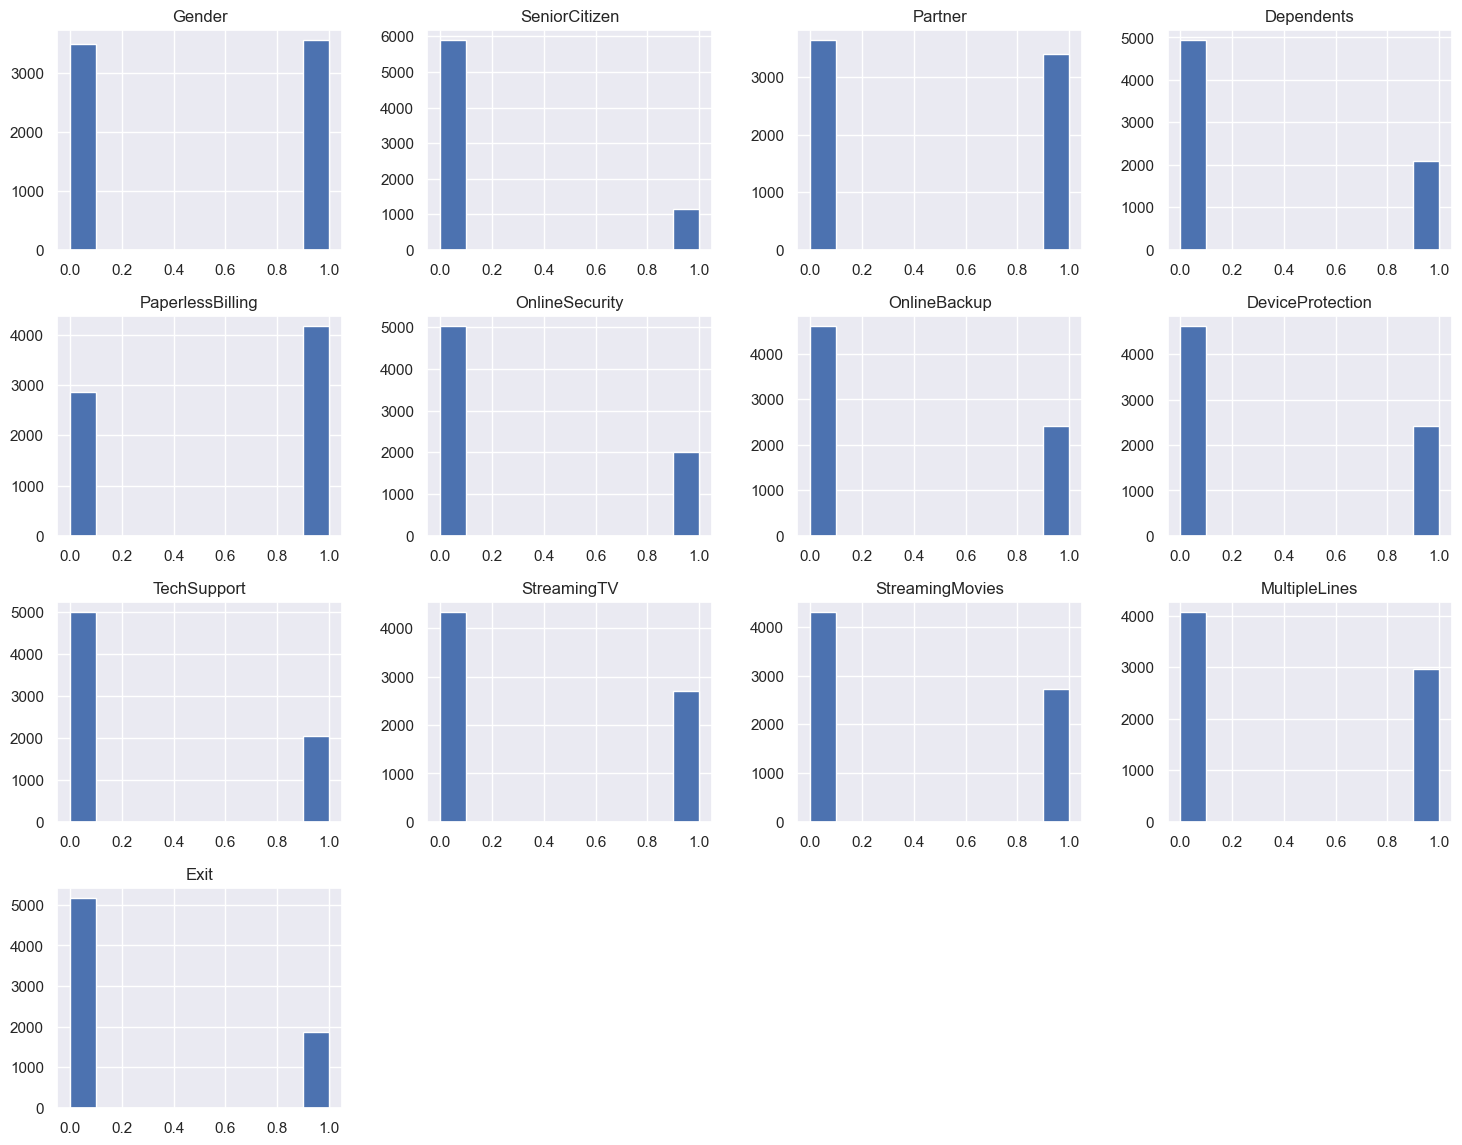

In [57]:
temp_df=full_df[cat_list]
fig = plt.figure(figsize = (18,14))
ax = fig.gca()
temp_df.hist(ax = ax)
fig = ax.get_figure()

Вывод

- Датасет не сбалансирован по целевому признаку
- Колонки  'Partner', 'Gender' имеют приблизительно одинаковое количество значений
- Большинство клиентов подключены к безбумажной оплате 'PaperlessBilling' 
- В остальных колонках превалирует значение 0

### Анализ мультиколлинеарности количественных признаков

Построим корреляцию количественных признаков

In [58]:
full_df[['MonthlyCharges','TotalCharges', 'Lifetime(days)', 'Exit']].corr()

,MonthlyCharges,TotalCharges,Lifetime(days),Exit
MonthlyCharges,1.000000,0.651065,0.246715,0.192858
TotalCharges,0.651065,1.000000,0.825811,-0.199484
Lifetime(days),0.246715,0.825811,1.000000,-0.354496
Exit,0.192858,-0.199484,-0.354496,1.000000


Вывод

Признаки 'MonthlyCharges', 'TotalCharges' коррелируют с целевым признаком

### Анализ мультиколлинеарности категоральных признаков

In [59]:
phik_overview = full_df.loc[:, ~full_df.columns.isin(['CustomerID', 'BeginDate', 'EndDate'])].phik_matrix()
phik_overview.round(2)

interval columns not set, guessing: ['Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines', 'Exit', 'Lifetime(days)']


,Gender,SeniorCitizen,Partner,Dependents,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Exit,Lifetime(days)
Gender,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.02,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00
SeniorCitizen,0.00,1.00,0.02,0.32,0.09,0.24,0.29,0.30,0.15,0.16,0.06,0.10,0.09,0.09,0.16,0.19,0.22,0.23,0.03
Partner,0.00,0.02,1.00,0.65,0.18,0.01,0.24,0.20,0.42,0.00,0.22,0.22,0.24,0.19,0.19,0.18,0.22,0.23,0.49
Dependents,0.00,0.32,0.65,1.00,0.15,0.17,0.22,0.18,0.12,0.11,0.12,0.03,0.01,0.10,0.02,0.06,0.03,0.25,0.21
Type,0.00,0.09,0.18,0.15,1.00,0.11,0.28,0.39,0.51,0.50,0.15,0.10,0.14,0.18,0.07,0.07,0.07,0.25,0.67
PaperlessBilling,0.00,0.24,0.01,0.17,0.11,1.00,0.37,0.47,0.21,0.23,0.00,0.20,0.16,0.06,0.34,0.33,0.25,0.30,0.00
PaymentMethod,0.00,0.29,0.24,0.22,0.28,0.37,1.00,0.40,0.35,0.32,0.26,0.28,0.31,0.27,0.38,0.38,0.34,0.45,0.37
MonthlyCharges,0.01,0.30,0.20,0.18,0.39,0.47,0.40,1.00,0.76,0.92,0.55,0.63,0.67,0.58,0.84,0.83,0.68,0.36,0.41
TotalCharges,0.00,0.15,0.42,0.12,0.51,0.21,0.35,0.76,1.00,0.51,0.55,0.66,0.67,0.57,0.66,0.67,0.61,0.28,0.84
InternetService,0.00,0.16,0.00,0.11,0.50,0.23,0.32,0.92,0.51,1.00,0.24,0.23,0.23,0.24,0.27,0.27,0.23,0.20,0.01


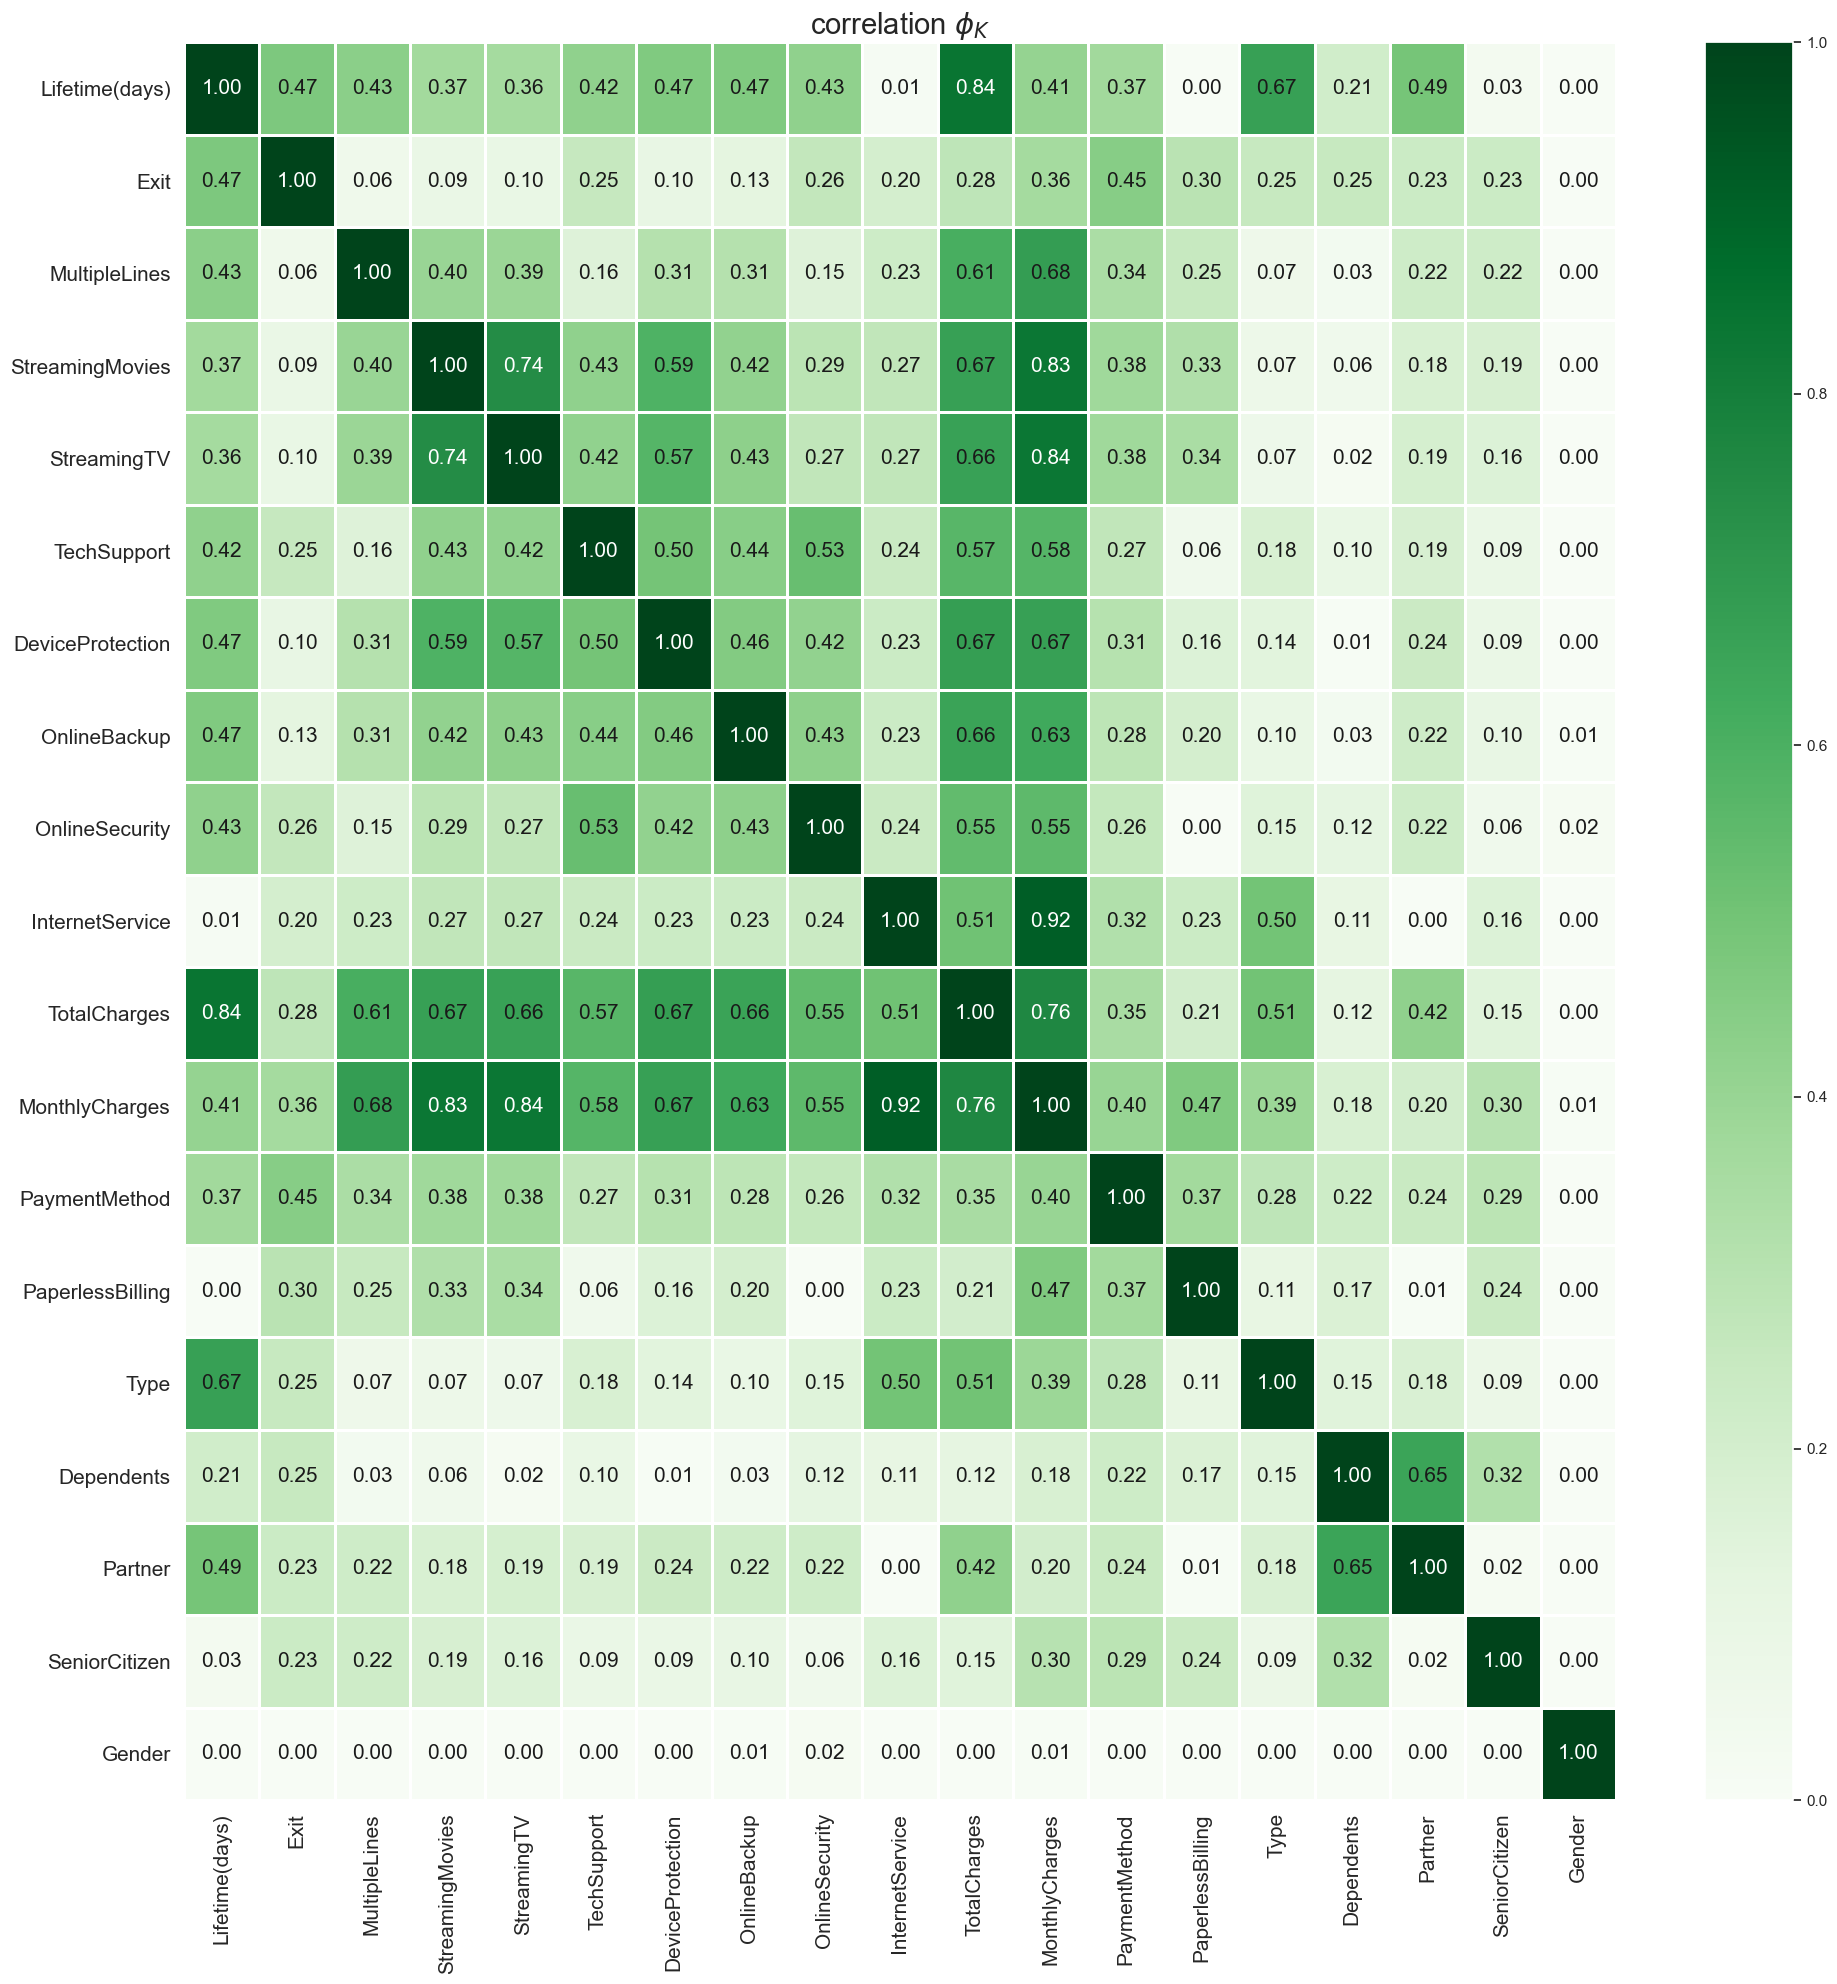

In [60]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(20, 20))
plt.tight_layout()

По результатам осмотра матрицы фико видим высокую корреляцию > 0.7 по следующим парам:
- 'Lifetime(days)':'TotalCharges'
- 'MonthlyCharges':'StreamingMovies'
- 'MonthlyCharges':'StreamingTV'
- 'MonthlyCharges':'IntenetService'
- 'MonthlyCharges':'TotalCharges'

interval columns not set, guessing: ['Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines', 'Exit', 'Lifetime(days)']


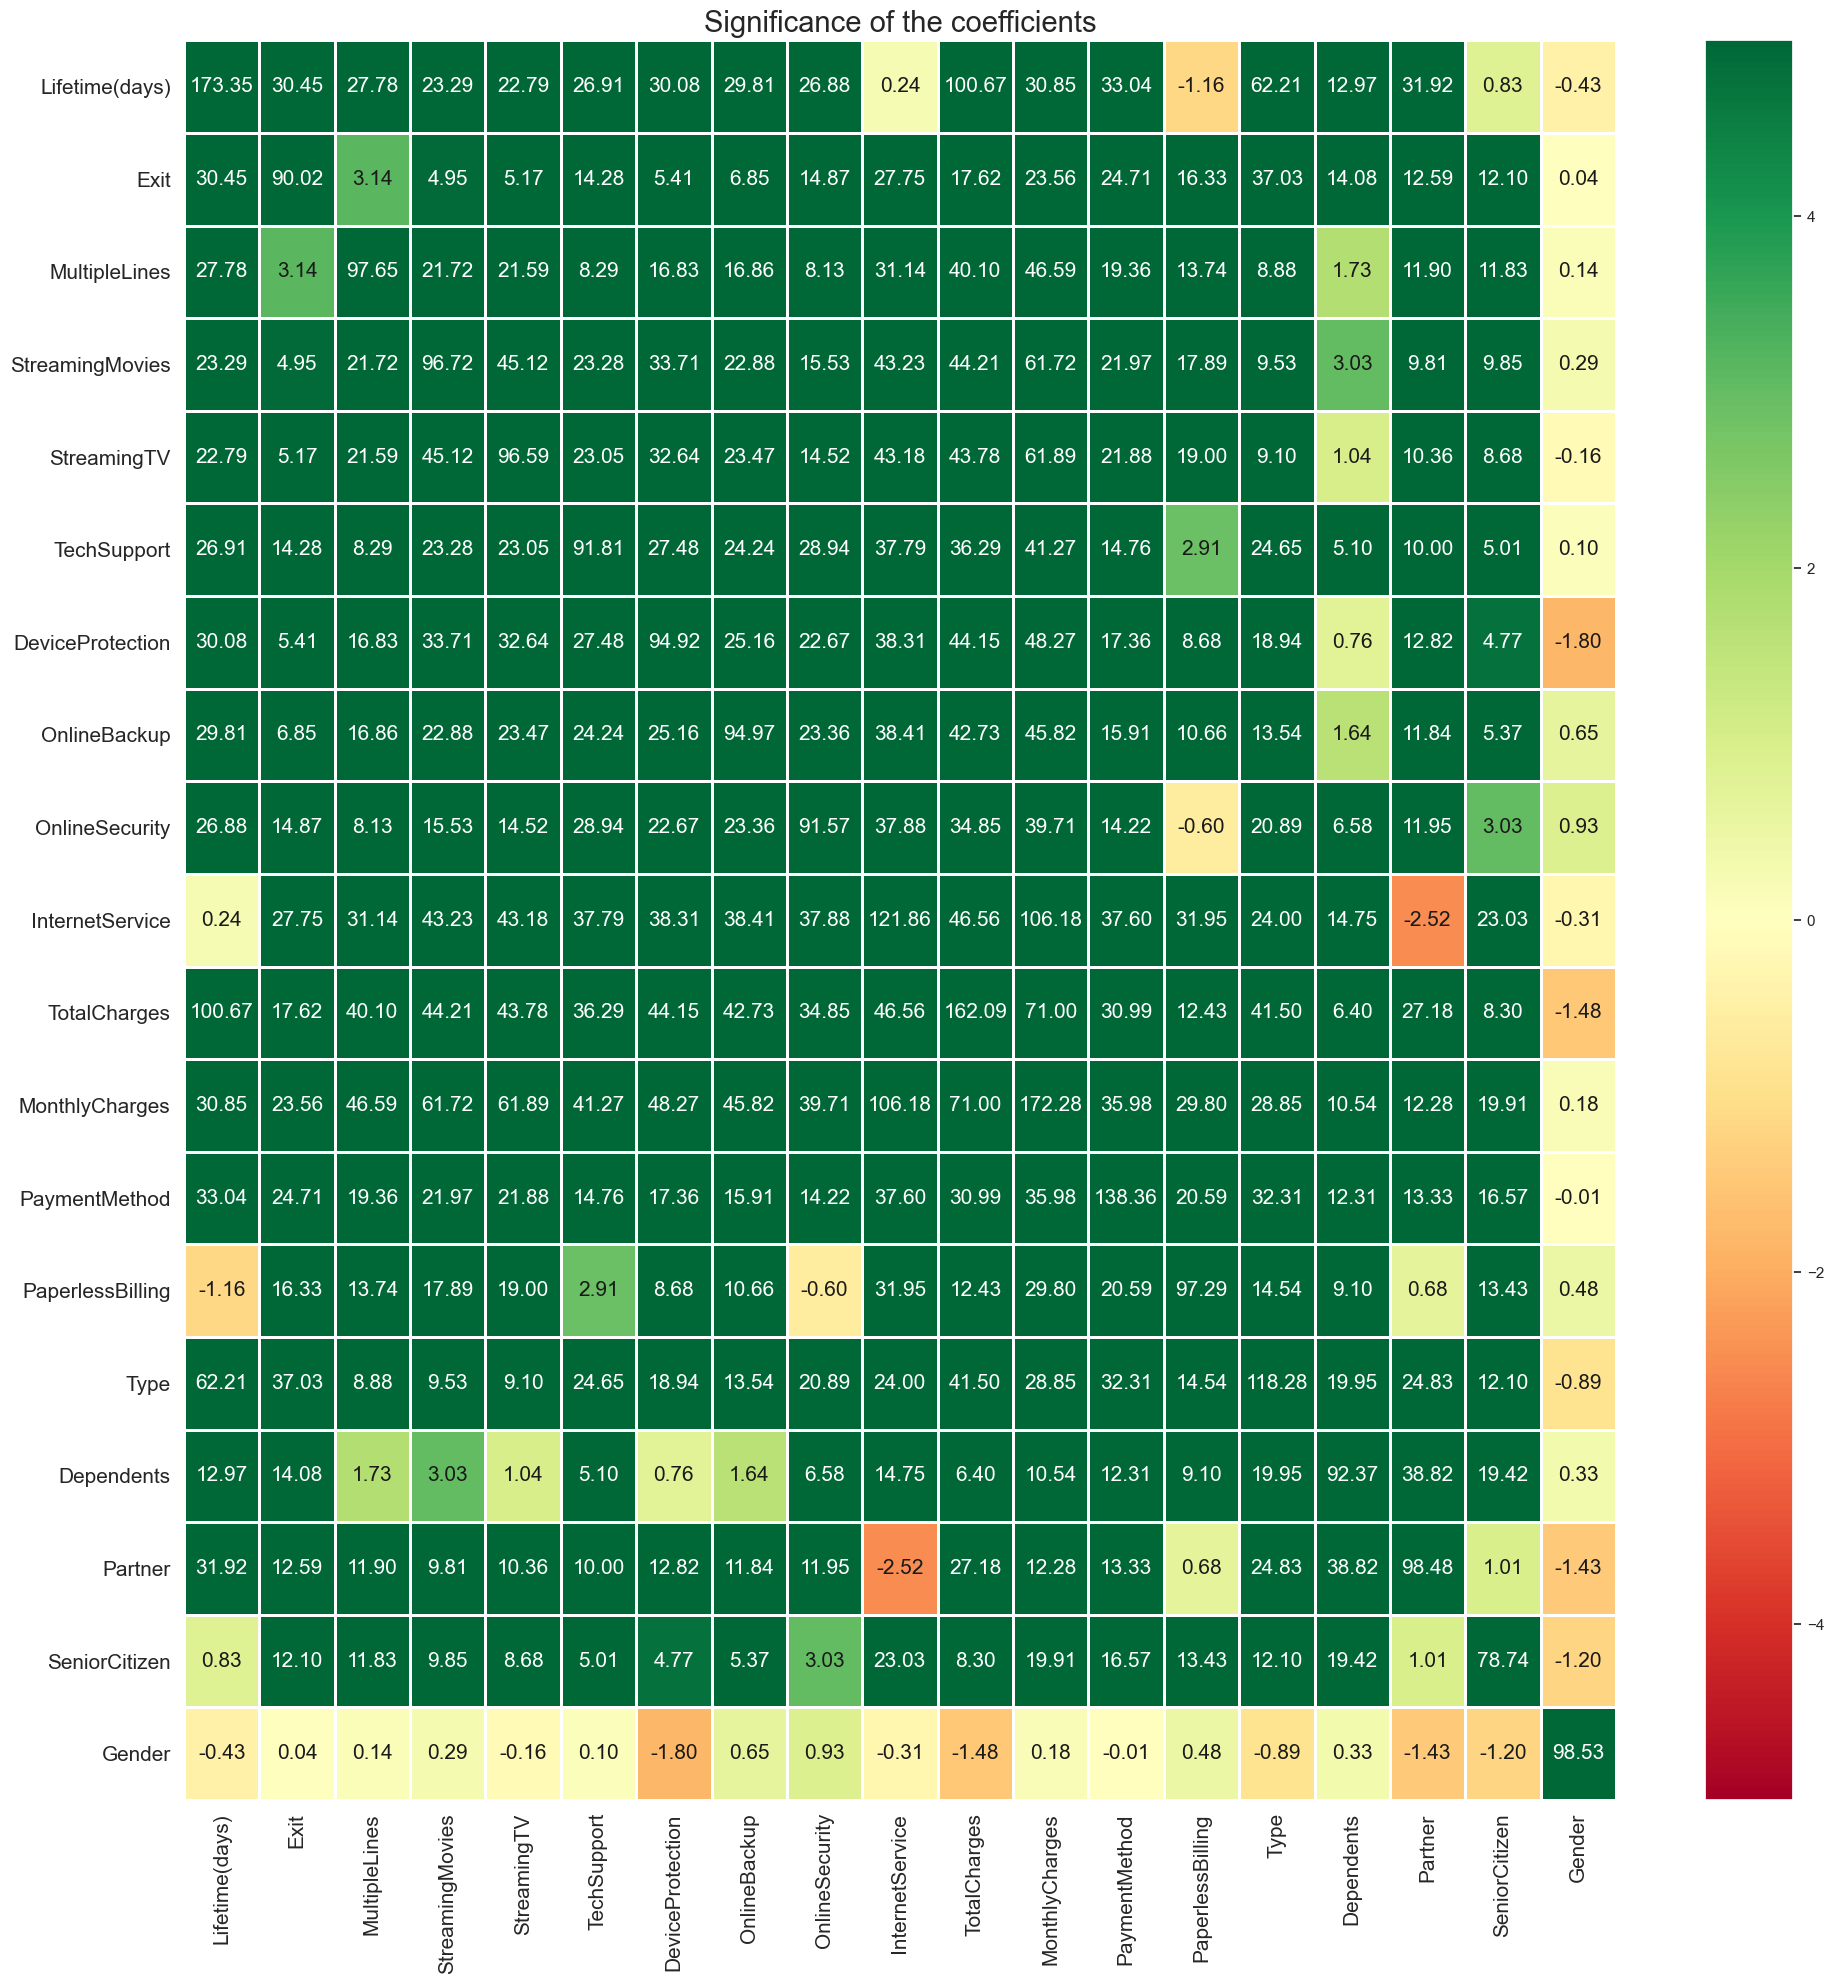

In [61]:
significance_overview = full_df.loc[:, ~full_df.columns.isin(['CustomerID', 'BeginDate', 'EndDate'])].significance_matrix()
plot_correlation_matrix(significance_overview.fillna(0).values, 
                        x_labels=significance_overview.columns, 
                        y_labels=significance_overview.index, 
                        vmin=-5, vmax=5, title="Significance of the coefficients", 
                        usetex=False, fontsize_factor=1.5, figsize=(20, 20))
plt.tight_layout()

Вывод

Изучив матрицу значимости видим, что все пары признаков с корреляцией > 0.7 статистически значимы:
- 'Lifetime(days)':'TotalCharges'
- 'MonthlyCharges':'StreamingMovies'
- 'MonthlyCharges':'StreamingTV'
- 'MonthlyCharges':'IntenetService'
- 'MonthlyCharges':'TotalCharges'

### Вывод

По результатам анализа:
- 'TotalCharges' и 'MonthlyCharges' имеют влияние на целевой признак
- Средняя сумма платежей по ушедшим клиентам в два раза меньше, чем по оставшимся клиентам
- Ушедшие клиенты в основном платили в месяц больше, чем оставшиеся клиенты
<br>
<br>
- Датасет не сбалансирован по целевому признаку
- Колонки  'Partner', 'Gender' имеют приблизительно одинаковое количество значений
- Большинство клиентов подключены к безбумажной оплате 'PaperlessBilling' 
- В остальных колонках превалирует значение 0
<br>
<br>
- Признаки 'MonthlyCharges', 'TotalCharges' коррелируют с целевым признаком
<br>
<br>
- На основе анализа корреляций видим, что все пары признаков с корреляцией > 0.7 статистически значимы:
    - 'Lifetime(days)':'TotalCharges'
    - 'MonthlyCharges':'StreamingMovies'
    - 'MonthlyCharges':'StreamingTV'
    - 'MonthlyCharges':'IntenetService'
    - 'MonthlyCharges':'TotalCharges'

## ПРЕДОБРАБОТКА ПРИЗНАКОВ

Удаление колонки BeginDate EndDate

In [62]:
full_df = full_df.drop(["BeginDate", "EndDate", 'CustomerID'], axis=1)

In [63]:
full_df.head(2)

,Gender,SeniorCitizen,Partner,Dependents,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Exit,Lifetime(days)
0,0,0,1,0,Month-to-month,1,Electronic check,29.85,29.85,DSL,0,1,0,0,0,0,0,0,31
1,1,0,0,0,One year,0,Mailed check,56.95,1889.50,DSL,1,0,1,0,0,0,0,0,1036


Запоминание списка признаков

In [64]:
features_names = list(set(full_df.columns) - set(['Exit']))

Разделение на признаки и на целевой признак

In [65]:
features = full_df.drop('Exit', axis=1)
target = full_df['Exit']

Анализ дисбаланса классов

In [66]:
print("В датасете, в", round(((full_df['Exit'] == 0).values).sum()/(full_df['Exit'] == 1).values.sum(),2),"раза количество оставшихся клиентов превышает количество ушедших.")


В датасете, в 2.76 раза количество оставшихся клиентов превышает количество ушедших.


Борьба с дисбалансом классов

In [67]:
#scale=((full_df['Exit'] == 0).values).sum()/(full_df['Exit'] == 1).values.sum()

def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=random_state)
    
    return features_upsampled, target_upsampled

#features_upsampled, target_upsampled = upsample(features, target, 3)

#print('features_upsampled',features_upsampled.shape)
#print('target_upsampled',target_upsampled.shape)

Разделение на обучающую и тестовую выборки

In [68]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=random_state)

In [69]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False, dtype='int')
ohe.fit(features_train[["Type", "PaymentMethod", "InternetService"]])

def get_ohe(df):
    temp_df = pd.DataFrame(data=ohe.transform(df[["Type", "PaymentMethod", "InternetService"]]), columns=ohe.get_feature_names_out())
    df.drop(columns=["Type", "PaymentMethod", "InternetService"], axis=1, inplace=True)
    df = pd.concat([df.reset_index(drop=True), temp_df], axis=1)
    return df

features_train = get_ohe(features_train)
features_test = get_ohe(features_test)

Масштабирование количественных признаков

In [70]:
numeric_cols = ['TotalCharges', 'MonthlyCharges', 'Lifetime(days)']
scaler = StandardScaler()
scaler.fit(features_train[numeric_cols])
features_train[numeric_cols] = scaler.transform(features_train[numeric_cols])
features_test[numeric_cols] = scaler.transform(features_test[numeric_cols])

Вывод

Признаки предобработаны

## Первичное тестирование и отбор моделей

## Отбор наилучшей модели

In [71]:
variable = ['roc_auc_best_score']
model = ['RandomForestClassifier', 'LGBMClassifier', 'CatBoostClassifier']
roc_auc_df = []

### Модель RandomForestClassifier

In [72]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 150, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [2,20]
# Minimum number of samples required to split a node
min_samples_split = [2, 15]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 20]
# Method of selecting samples for training each tree
bootstrap = [True, False]

param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf_Model = RandomForestClassifier(random_state=random_state)

rf_Grid = GridSearchCV(estimator = rf_Model, param_grid = param_grid, cv = 5, verbose=0, scoring='roc_auc')
rf_Grid.fit(features_train, target_train)

print('-----------------------')
print('Лучшие параметры модели:')
print(rf_Grid.best_estimator_)
print('')
print('roc_auc на обучающей выборке:')
print(rf_Grid.best_score_)
print('-----------------------')

rf_Grid_best_model = rf_Grid.best_estimator_

#pred_target = rf_Grid.best_estimator_.predict(features_test)
#pred_proba = rf_Grid.best_estimator_.predict_proba(features_test)[:, 1]

roc_auc_df.append(round(rf_Grid.best_score_,4))
#accuracy_score_df.append(round(accuracy_score(target_test, pred_target),4))

-----------------------
Лучшие параметры модели:
RandomForestClassifier(max_depth=20, max_features='auto', min_samples_split=15,
                       n_estimators=87, random_state=120922)

roc_auc на обучающей выборке:
0.8592112838157007
-----------------------


### Модель LGBMClassifier

In [73]:
params = {
    'n_estimators': range(100, 600, 100),
    'max_depth': range(5, 13, 2),
    'num_leaves': range(30, 120, 10),
    'min_child_samples': range(20, 100, 10)
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

lgbm_RandomGrid = RandomizedSearchCV(lgb.LGBMClassifier(random_state=random_state, is_unbalance=False), 
                                     params, 
                                     verbose=1, 
                                     scoring='roc_auc',
                                     n_iter=50,
                                     cv=skf,
                                     random_state = random_state,
                                    return_train_score=True)

lgbm_RandomGrid.fit(features_train, target_train)


print('-----------------------')
print('Лучшие параметры модели:')
print(lgbm_RandomGrid.best_estimator_)
print('')
print('roc_auc на обучающей выборке:')
print(lgbm_RandomGrid.best_score_)
print('-----------------------')

best_lgbm_classifier = lgb.LGBMClassifier(max_depth = lgbm_RandomGrid.best_params_["max_depth"],
                           n_estimators  = lgbm_RandomGrid.best_params_["n_estimators"],
                           num_leaves     = lgbm_RandomGrid.best_params_["num_leaves"],
                           min_child_samples = lgbm_RandomGrid.best_params_["min_child_samples"] ,             
                           metric='auc')


roc_auc_df.append(round(lgbm_RandomGrid.best_score_,4))
#best_lgbm_classifier.fit(features_train, target_train)

#predictions = best_lgbm_classifier.predict(features_test)
#pred_proba = best_lgbm_classifier.predict_proba(features_test)[:, 1]

#roc_auc_df.append(round(metrics.roc_auc_score(target_test, pred_proba),4))
#accuracy_score_df.append(round(accuracy_score(target_test, predictions),4))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
-----------------------
Лучшие параметры модели:
LGBMClassifier(is_unbalance=False, max_depth=5, min_child_samples=70,
               n_estimators=500, num_leaves=110, random_state=120922)

roc_auc на обучающей выборке:
0.8920647427744074
-----------------------


### Модель CatBoostClassifier

In [74]:
param_grid = {
        'learning_rate': [0.1, 0.2],
        'depth': [10, 40],
        'l2_leaf_reg': [2, 8],
        'iterations':[40, 320],
        'thread_count':[14],
        'border_count':[124]
}

cb_model = CatBoostClassifier(loss_function='Logloss',eval_metric='AUC', random_seed=random_state, verbose=0)

cb_grid_search = GridSearchCV(estimator=cb_model, param_grid=param_grid, scoring='roc_auc', cv=5)
cb_grid_search.fit(features_train, target_train)

print('-----------------------')
print('Лучшие параметры модели:')
print(cb_grid_search.best_params_)
print('')
print('roc_auc на обучающей выборке:')
print(cb_grid_search.best_score_)
print('-----------------------')


best_cb_classifier = CatBoostClassifier(learning_rate=cb_grid_search.best_params_['learning_rate'],
                           thread_count=cb_grid_search.best_params_['thread_count'],
                           border_count=cb_grid_search.best_params_['border_count'],
                           iterations=cb_grid_search.best_params_['iterations'],
                           depth=cb_grid_search.best_params_['depth'],
                           l2_leaf_reg=cb_grid_search.best_params_['l2_leaf_reg'],
                           loss_function='Logloss', eval_metric='AUC', random_seed=random_state, verbose=0
                          )



roc_auc_df.append(round(cb_grid_search.best_score_,4))
#best_cb_classifier.fit(features_train, target_train)

#predictions = best_cb_classifier.predict(features_test)
#pred_proba = best_cb_classifier.predict_proba(features_test)[:, 1]

#roc_auc_df.append(round(metrics.roc_auc_score(target_test, pred_proba),4))
#accuracy_score_df.append(round(accuracy_score(target_test, predictions),4))

TBB Warning: The number of workers is currently limited to 3. The request for 13 workers is ignored. Further requests for more workers will be silently ignored until the limit changes.



-----------------------
Лучшие параметры модели:
{'border_count': 124, 'depth': 10, 'iterations': 320, 'l2_leaf_reg': 8, 'learning_rate': 0.1, 'thread_count': 14}

roc_auc на обучающей выборке:
0.8846534072469142
-----------------------


Лучшие параметры модели:
{'border_count': 124, 'depth': 10, 'iterations': 240, 'l2_leaf_reg': 8, 'learning_rate': 0.1, 'thread_count': 14}

roc_auc на обучающей выборке:
0.8850193918416902

In [75]:
res_df = pd.DataFrame(np.column_stack([roc_auc_df]), 
                               columns=variable, index=model)
print('Результаты на тестовой выборке:')
display(res_df)

Результаты на тестовой выборке:


,roc_auc_best_score
RandomForestClassifier,0.8592
LGBMClassifier,0.8921
CatBoostClassifier,0.8847


In [76]:
print(res_df.to_markdown())

|                        |   roc_auc_best_score |
|:-----------------------|---------------------:|
| RandomForestClassifier |               0.8592 |
| LGBMClassifier         |               0.8921 |
| CatBoostClassifier     |               0.8847 |


Вывод:

На поиске лучшей модели удалось добится следующих результатов:

|                        |   roc_auc_best_score |
|:-----------------------|---------------------:|
| RandomForestClassifier |               0.8592 |
| LGBMClassifier         |               0.8921 |
| CatBoostClassifier     |               0.8847 |

LGBMClassifier показал наилучшие результаты.

## Тестирование финальной модели

In [77]:
best_lgbm_classifier.fit(features_train, target_train)
pred_proba = best_lgbm_classifier.predict_proba(features_test)[:, 1]

print("Результат AUC_ROC на тестовой выборке:", round(metrics.roc_auc_score(target_test, pred_proba),4))

Результат AUC_ROC на тестовой выборке: 0.8968


# Вывод

**1. Загрузка данных и изучение общей информации**<br>
Необходимо перевести значения из таблицы personal:
- столбцов Partner к численному (0 и 1).

Необходимо перевести значения из таблицы contract:
- столбца BeginDate к типу даты;
- на основе столбца EndDate сформировать целевой признак (название Exit с наполнением no это 1);
- столбца TotalCharges к типу float;
- столбцов PaperlessBilling и Dependents к численному (0 и 1).

Необходимо перевести значения из таблицы internet:
- столбца InternetService к категоральному типу;
- столбцов OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies к численному (0 и 1).

Необходимо перевести значения из таблицы phone:
- столбца MultipleLines к численному (0 и 1).

**2. Предобработка данных**<br>
- Целевой признак сформирован 'Exit' - открыт договор или закрыт на дату 2020-02-01
- Заменены типы колонок 
    - тип колонки 'BeginDate' на datetime
    - тип колонки 'TotalCharges' на float64
    - изменены типы столбцов с Yes, No на 1, 0 по списку 'Partner', 'Dependents', 'PaperlessBilling', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines'
    - Сформирована колонка отображающая срок жизни клиента на обслуживании Lifetime(days)
    - Пропуски в колонке 'InternetService' заполнены значением None
    
**3. Исследовательский анализ данных**<br>
По результатам исследовательского анализа:
- 'TotalCharges' и 'MonthlyCharges' имеют влияние на целевой признак
- Средняя сумма платежей по ушедшим клиентам в два раза меньше, чем по оставшимся клиентам
- Ушедшие клиенты в основном платили в месяц больше, чем оставшиеся клиенты
<br>
<br>
- Датасет не сбалансирован по целевому признаку
- Колонки  'Partner', 'Gender' имеют приблизительно одинаковое количество значений
- Большинство клиентов подключены к безбумажной оплате 'PaperlessBilling' 
- В остальных колонках превалирует значение 0
<br>
<br>
- Признаки 'MonthlyCharges', 'TotalCharges' коррелируют с целевым признаком
<br>
<br>
- На основе анализа корреляций видим, что все пары признаков с корреляцией > 0.7 статистически значимы:
    - 'Lifetime(days)':'TotalCharges'
    - 'MonthlyCharges':'StreamingMovies'
    - 'MonthlyCharges':'StreamingTV'
    - 'MonthlyCharges':'IntenetService'
    - 'MonthlyCharges':'TotalCharges'

**4. Отбор лучшей модели**<br>
На поиске лучшей модели удалось добится следующих результатов:

|                        |   roc_auc_best_score |
|:-----------------------|---------------------:|
| RandomForestClassifier |               0.8592 |
| LGBMClassifier         |               0.8921 |
| CatBoostClassifier     |               0.8847 |

LGBMClassifier показал наилучшие результаты.

**5. Тестирование лучшей модели**<br>
Результаты лучшей модели LGBMClassifier на тестовых данных:

|                        |   roc_auc |
|:-----------------------|----------:|
| LGBMClassifier         |    0.8968 |